In [1]:
%matplotlib inline
# to install watermark magic command: pip install ipyext
%load_ext watermark 
%watermark -v -p numpy,scipy,pandas,matplotlib,seaborn,sklearn

CPython 3.5.2
IPython 4.2.0

numpy 1.11.2
scipy 0.18.1
pandas 0.19.1
matplotlib 1.5.1
seaborn 0.7.1
sklearn 0.18.1


In [2]:
def make_dist_mar_vars(wells_df):
 
    grouped = wells_df.groupby(['Well Name'])
    new_df = pd.DataFrame()
    
    for key in grouped.groups.keys():
    
        NM_M = grouped.get_group(key)['NM_M'].values

        #We create a temporary dataframe that we reset for every well
        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        temp_df['Well Name'] = [key for _ in range(len(NM_M))]

        #We initialize new variables
        dist_mar_up = np.zeros(len(NM_M))
        dist_mar_down = np.zeros(len(NM_M))

        # A variable counting the interval from the upper marine deposit an one for bottom lower deposit
        # We initialize them to -99999 since we do not know what's above the first log
        count = -99999
        
        #we build them in two seperate loops
        for i in range(len(NM_M)):

            if ((NM_M[i] == 1) & (count>-99999)):

                count+=0.5
                dist_mar_up[i] += count

            elif NM_M[i] == 2:

                count=0

            else:
                dist_mar_up[i] = count

        #********************************************#
        #we reset count
        count = -99999
        
        for i in range(len(NM_M)-1,-1,-1):
               
            if ((NM_M[i] == 1) & (count>-99999)):

                count+=0.5
                dist_mar_down[i] += count

            elif NM_M[i] == 2:            
                count=0

            else:
                dist_mar_down[i] = count
                
        #********************************************#       

        temp_df['dist_mar_up'] = dist_mar_up
        temp_df['dist_mar_down'] = dist_mar_down
#         temp_df['ratio_NM_M'] = [np.mean(NM_M[i:i+50]) if i<(len(NM_M)-50) else np.mean(NM_M[i:]) for i in range(len(NM_M))]
    
        # We append each well variable to a larger dataframe
        # We use a dataframe to preserve the index
        new_df = new_df.append(temp_df) 
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    
    #We don't use merge as it creates duplicates for curious reasons that we later have to drop
    return pd.concat([wells_df,new_df],axis=1)

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import preprocessing

from pandas import set_option
set_option("display.max_rows",10)
pd.options.mode.chained_assignment = None

# turn off ipython warnings 
import warnings
warnings.filterwarnings('ignore')

filename = 'data/facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [4]:
filename = 'data/validation_data_nofacies.csv'
test_data = pd.read_csv(filename)
test_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911
...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556


In [5]:
full_data = test_data.append(training_data.drop(['Facies'],axis=1))

explained variance ratio (first two components): [ 0.92030266  0.05768463]


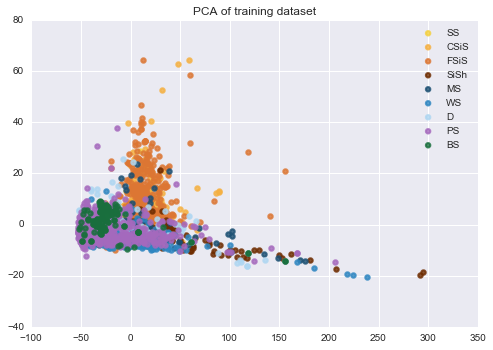

In [6]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
idx = training_data['PE'].notnull()

X = (training_data[idx].drop(['Facies','Formation','Well Name','Depth'],axis=1)).values
y = training_data[idx]['Facies'].values
target_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
lw = 2

for color, i, target_name in zip(colors, range(1,10), target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of training dataset');

In [7]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import metrics
from sklearn import neighbors

logo = LeaveOneGroupOut()
svm = SVC(C=5)
clf = neighbors.KNeighborsClassifier(5, weights='distance')

In [8]:
scores=[]
names = training_data['Well Name']
for train, test in logo.split(X, y, groups=training_data[idx]['Well Name']):
    
    clf.fit(X_r[train],y[train])
    y_pred = clf.predict(X_r[test])


    
    conf_mat = metrics.confusion_matrix(y[test],y_pred)
    print(conf_mat)
    
    score = metrics.f1_score(y[test], y_pred,average='weighted')
    
    scores.append(score)
    print('********')
    print('Blind well is {0}, F1 score : {1:.4%}\n'.format(names[test[0]],score))



print("="*30)
print('*********** RESULT ***********')
print("="*30)
print('\nAverage  F1-score is {:.4%}'.format(np.mean(scores)))

[[ 1  4  2  1  0  0  0  0  0]
 [ 6 22 22  2  1  3  0  0  0]
 [ 0 11 36  3  1  0  0  0  0]
 [ 1  4  5  2  0  1  0  0  0]
 [ 2  2  4  2  9 10  0  1  0]
 [ 1  7  4  2  5 52  0 14  2]
 [ 0  3 13  6  3  1  0  4  4]
 [ 2  6  7  4  2 24  1 23  6]
 [ 0  0  0  0  0  0  0  0 50]]
********
Blind well is NOLAN, F1 score : 45.7236%

[[42 62 22  7  3 11  1  5  5]
 [ 3 44 78  5  2  9  0  1  0]
 [ 0  6 33  0  1  3  0  2  2]
 [ 0  1  3  4  0  8  3  6  0]
 [ 1  1  6  2  2 14  0  1  1]
 [ 0  8  3  2  4  8  0  6  0]
 [ 0  0  1  0  0  0  1  0  0]
 [ 2 15 10  2  1 14  3 17  4]
 [ 0  0  0  0  0  0  0  0  0]]
********
Blind well is SHANKLE, F1 score : 31.6878%

[[ 0  0  0  0  0  0  0  0  0]
 [19 64 16  9  4  3  1  1  0]
 [10 47 52  3  4  1  3  6  3]
 [ 3  9  9  4  1  1  2  5  1]
 [ 0  0  0  0  0  1  0  1  0]
 [ 4  7  2  7 10 40  0 14  0]
 [ 2  0  1  0  0  4  1  8  4]
 [ 2  4  1  1  4 14  2 40  6]
 [ 0  0  0  0  0  0  0  0  0]]
********
Blind well is ALEXANDER D, F1 score : 46.7538%

[[ 0  0  0  0  0  0  0  0 

In [9]:
training_data = make_dist_mar_vars(training_data)

In [10]:
X = np.zeros((len(X_r),4))
X[:,0]=training_data[idx].dist_mar_up.values
X[:,1]=training_data[idx].dist_mar_down.values
X[:,2:]=X_r

In [11]:
scores=[]
names = training_data['Well Name']
for train, test in logo.split(X, y, groups=training_data[idx]['Well Name']):
    
    clf.fit(X[train],y[train])
    y_pred = clf.predict(X[test])


    
    conf_mat = metrics.confusion_matrix(y[test],y_pred)
    print(conf_mat)
    
    score = metrics.f1_score(y[test], y_pred,average='weighted')
    
    scores.append(score)
    print('********')
    print('Blind well is {0}, F1 score : {1:.4%}\n'.format(names[test[0]],score))



print("="*30)
print('*********** RESULT ***********')
print("="*30)
print('\nAverage  F1-score is {:.4%}'.format(np.mean(scores)))

[[ 0  5  3  0  0  0  0  0  0]
 [ 0 35 19  0  1  1  0  0  0]
 [ 0 10 35  2  2  0  0  2  0]
 [ 0  1  0  4  1  4  0  2  1]
 [ 0  1  1  2  9 13  0  3  1]
 [ 0  0  2  7  8 53  0 15  2]
 [ 0  1  1 11  4  1  1 10  5]
 [ 0  1  3  9  3 27  1 25  6]
 [ 0  0  0  0  0  0  0  0 50]]
********
Blind well is NOLAN, F1 score : 49.8796%

[[60 25 73  0  0  0  0  0  0]
 [ 3 55 83  0  0  0  0  1  0]
 [ 0  7 36  0  0  1  0  1  2]
 [ 0  0  5  4  0  8  3  5  0]
 [ 4  0  5  3  1 14  0  0  1]
 [ 0  0  0  5  5 15  0  6  0]
 [ 0  0  1  0  0  0  1  0  0]
 [ 0  1  6  9  2 21  2 22  5]
 [ 0  0  0  0  0  0  0  0  0]]
********
Blind well is SHANKLE, F1 score : 42.1524%

[[ 0  0  0  0  0  0  0  0  0]
 [20 74 22  0  1  0  0  0  0]
 [15 41 65  0  2  1  1  3  1]
 [ 0  0  0 12  3  3  2 14  1]
 [ 0  0  0  0  0  1  0  1  0]
 [ 0  0  0  8 16 44  0 16  0]
 [ 0  0  0  1  1  4  1 10  3]
 [ 0  0  2  3  4 16  3 39  7]
 [ 0  0  0  0  0  0  0  0  0]]
********
Blind well is ALEXANDER D, F1 score : 54.7422%

[[ 0  0  0  0  0  0  0  0 